In [1]:
import torch

In [2]:
from sudo_rm_rf.dnn.models import causal_improved_sudormrf_v3

In [3]:
import soundfile as sf

In [4]:
from os.path import join as pjoin

In [5]:
import time as t

In [6]:
import sudo_rm_rf.dnn.losses.sisdr as sisdr_lib

In [7]:
import numpy as np

In [8]:
import tqdm

In [32]:
import matplotlib.pyplot as plt

In [9]:
# Function that loads the multi-GPU saved SudorRMRF_causal_v3 weights for CPU inference
def load_sudormrf_causal_cpu(model_path):
    model = causal_improved_sudormrf_v3.CausalSuDORMRF(
        in_audio_channels=1,
        out_channels=512,
        in_channels=256,
        num_blocks=16,
        upsampling_depth=5,
        enc_kernel_size=21,
        enc_num_basis=512,
        num_sources=2,
        )
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    device = torch.device("cpu")
    model = model.module.to(device)    
    model.eval()
    return model

In [10]:
fs = 16000

In [11]:
models_dir = pjoin(pjoin(pjoin('sudo_rm_rf', 'dnn'), 'experiments'), 'checkpoints')
model_path = pjoin(pjoin(models_dir, 'e14_sudo_whamr_16k_sepnoisy_augment'), 'causal_sudo_epoch_100.pt')
model = load_sudormrf_causal_cpu(model_path)

In [12]:
#now load an audio file and run inference...

In [13]:
whamr_path = pjoin(pjoin(pjoin(pjoin('/media', 'enricguso'), 'datasets'), 'Data'), 'whamr')#/wav16k/min/tt'
fs_path = pjoin(whamr_path, 'wav16k')
mode_path = pjoin(fs_path, 'min')
tt_path = pjoin(mode_path, 'tt')

mixture_name = '22ga010d_1.5482_052o020t_-1.5482.wav'
s1_path = pjoin(pjoin(tt_path, 's1_anechoic'), mixture_name)
s2_path = pjoin(pjoin(tt_path, 's2_anechoic'), mixture_name)
noise_path = pjoin(pjoin(tt_path, 'noise'), mixture_name)

In [14]:
s1, _ = sf.read(s1_path)
s2, _ = sf.read(s2_path)
noise, _ = sf.read(noise_path)

In [15]:
mixture = s1 + s2 + noise

In [16]:
mixture = torch.tensor(mixture, dtype=torch.float32)

In [17]:
audio_length = len(mixture) / fs

In [18]:
loss = sisdr_lib.PITLossWrapper(sisdr_lib.PairwiseNegSDR("sisdr"),
                         pit_from='pw_mtx')

In [19]:
targets = torch.tensor(np.array([s1, s2]), dtype=torch.float32)

In [21]:
# test how performance degrades when using short chunks

In [22]:
num_chunks = (np.linspace(1, 800, num=100)).astype('int').tolist()

In [23]:
times = []
sisdrs = []
chunk_sizes = []
for chunks in tqdm.tqdm(num_chunks):
    try:
        if chunks == 1:
            mix_list = [mixture]
        else:
            # split into simple chunks (rectangular window and no overlap), dropping the last one
            mix_list = torch.split(mixture, len(mixture) // chunks)[0:-1]
        chunk_sizes.append(len(mix_list[0]))
        #targets_list = torch.split(targets, len(mixture) // chunks, dim=1)[0:-1]
        # compute the audio
        rec_sources = []
        tic = t.time()
        for m in mix_list:
            rec_sources.append(model(m.unsqueeze(0).unsqueeze(1)).squeeze())
        rec_sources = torch.cat(rec_sources, dim=1)
        sisdrs.append(loss(rec_sources.unsqueeze(0), targets[:, :rec_sources.shape[1]].unsqueeze(0)).item())
        tac = t.time()
        times.append(tac - tic)
    except:
        times.append('nan')
        sisdrs.append('nan')
        chunk_sizes('nan')

100%|█████████████████████████████████████████| 100/100 [16:27<00:00,  9.87s/it]


In [26]:
ms_sizes = [x*1000 / fs for x in chunk_sizes]

In [28]:
results = {'times' : times, 'sisdrs' : sisdrs, 'ms_sizes' : ms_sizes}

In [30]:
np.save('realtime_factor_test.npy', results)

In [66]:
len(mixture)/fs

5.46

In [67]:
realtime_factor = [x/(len(mixture)/fs) for x in times]

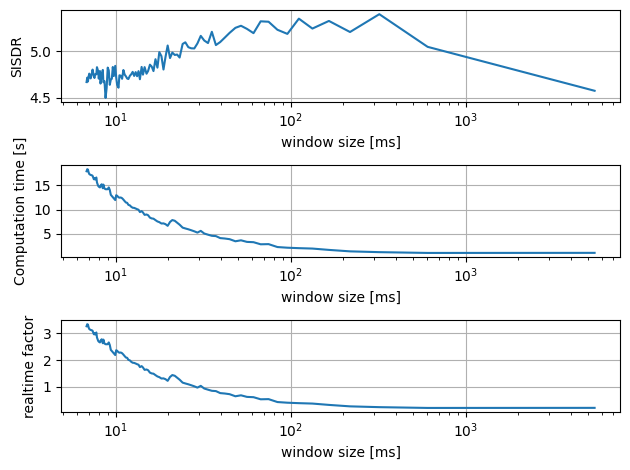

In [68]:
plt.subplot(3,1,1)
plt.semilogx(ms_sizes, sisdrs)

plt.ylabel('SISDR')
plt.xlabel('window size [ms]')
plt.tight_layout()
plt.grid(True)

plt.subplot(3,1,2)
plt.semilogx(ms_sizes, times)
plt.ylabel('Computation time [s]')
plt.xlabel('window size [ms]')
plt.tight_layout()
plt.grid(True)

plt.subplot(3,1,3)
plt.semilogx(ms_sizes, realtime_factor)
plt.ylabel('realtime factor')
plt.xlabel('window size [ms]')
plt.tight_layout()
plt.grid(True)